In [1]:
# 🛠️ SETUP
!pip install PyPDF2 pandas nltk spacy gensim scikit-learn matplotlib seaborn -q
import nltk
nltk.download('stopwords')
!python -m spacy download en_core_web_sm
!pip install pyLDAvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 560.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 36.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.3 MB/s eta 0:00:00


In [1]:
# 📚 IMPORTS
import os
import re
import PyPDF2
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.colab import files

# 🔧 INIT
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


In [4]:
uploaded = files.upload()

Saving ENG_PDF.zip to ENG_PDF.zip


In [6]:
# Unzip the uploaded zip file (replace with your zip name)
!unzip ENG_PDF.zip -d gdpr_pdfs

Archive:  ENG_PDF.zip
  inflating: gdpr_pdfs/ETid-570.pdf  
  inflating: gdpr_pdfs/ETid-689.pdf  
  inflating: gdpr_pdfs/ETid-752.pdf  
  inflating: gdpr_pdfs/ETid-820.pdf  
  inflating: gdpr_pdfs/ETid-847.pdf  
  inflating: gdpr_pdfs/ETid-875.pdf  
  inflating: gdpr_pdfs/ETid-893.pdf  
  inflating: gdpr_pdfs/ETid-930.pdf  
  inflating: gdpr_pdfs/ETid-987.pdf  
  inflating: gdpr_pdfs/ETid-1009.pdf  
  inflating: gdpr_pdfs/ETid-1188.pdf  
  inflating: gdpr_pdfs/ETid-1190.pdf  
  inflating: gdpr_pdfs/ETid-1250.pdf  
  inflating: gdpr_pdfs/ETid-1352.pdf  
  inflating: gdpr_pdfs/ETid-1373.pdf  
  inflating: gdpr_pdfs/ETid-1422.pdf  
  inflating: gdpr_pdfs/ETid-1461.pdf  
  inflating: gdpr_pdfs/ETid-1543.pdf  
  inflating: gdpr_pdfs/ETid-1564.pdf  
  inflating: gdpr_pdfs/ETid-1578.pdf  
  inflating: gdpr_pdfs/ETid-1666.pdf  
  inflating: gdpr_pdfs/ETid-1677.pdf  
  inflating: gdpr_pdfs/ETid-1696.pdf  
  inflating: gdpr_pdfs/ETid-1844.pdf  
  inflating: gdpr_pdfs/ETid-1910.pdf  
  inflating:

In [7]:
# 📥 1. Extract text from PDFs
def extract_text_from_pdfs(pdf_dir):
    texts = {}
    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            with open(os.path.join(pdf_dir, filename), 'rb') as f:
                reader = PyPDF2.PdfReader(f)
                text = " ".join(page.extract_text() for page in reader.pages)
                texts[filename] = text
    return texts

# Replace with your path
pdf_dir = 'gdpr_pdfs'  # Adjust if needed
texts = extract_text_from_pdfs(pdf_dir)
print(f"Extracted {len(texts)} PDF(s). Sample:\n{list(texts.keys())[:2]}")


[0, IndirectObject(2850, 0, 135468802642896)]
[0, IndirectObject(2845, 0, 135468802642896)]
[0, IndirectObject(2836, 0, 135468802642896)]
[0, IndirectObject(2831, 0, 135468802642896)]
[0, IndirectObject(2826, 0, 135468802642896)]
[0, IndirectObject(2821, 0, 135468802642896)]
[0, IndirectObject(2895, 0, 135468802642896)]
[0, IndirectObject(2938, 0, 135468802642896)]
[0, IndirectObject(2931, 0, 135468802642896)]
[0, IndirectObject(4243, 0, 135468802642896)]
[0, IndirectObject(4228, 0, 135468802642896)]
[0, IndirectObject(4115, 0, 135468802642896)]
[0, IndirectObject(4049, 0, 135468802642896)]
[0, IndirectObject(3896, 0, 135468802642896)]
[0, IndirectObject(3521, 0, 135468802642896)]
[0, IndirectObject(3297, 0, 135468802642896)]
[0, IndirectObject(3144, 0, 135468802642896)]
[0, IndirectObject(3138, 0, 135468802642896)]
[0, IndirectObject(3133, 0, 135468802642896)]
[0, IndirectObject(351, 0, 135468769202128)]
[0, IndirectObject(354, 0, 135468769202128)]
[0, IndirectObject(357, 0, 135468769

Extracted 37 PDF(s). Sample:
['ETid-847.pdf', 'ETid-60.pdf']


In [8]:
df_meta=pd.read_excel('ALL_metadata.xlsx')
df_meta.head()

,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting","Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art...",Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",link,https://www.enforcementtracker.com/ETid-2566 (...
1,NaN,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,link link,https://www.enforcementtracker.com/ETid-2561 (...
2,NaN,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,link link,https://www.enforcementtracker.com/ETid-2555 (...
3,NaN,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...,link link,https://www.enforcementtracker.com/ETid-2317 (...
4,NaN,ETid-2170,UNITED KINGDOM,Information Commissioner (ICO),2023-12-13 00:00:00,400000,UK Ministry of Defense,Public Sector and Education,Unknown,Insufficient technical and organisational meas...,The UK DPA has fined the Ministry of Defense E...,link,https://www.enforcementtracker.com/ETid-2170 (...


In [9]:
# prompt: help me filter the df_meta usiing the filename from texts on column Etid and replace the .pdf from filenames

def filter_and_replace(df, texts):
    """Filters the DataFrame based on filenames in 'texts' and replaces .pdf."""

    # Extract filenames without .pdf extension from the texts dictionary keys
    filenames_no_pdf = [filename[:-4] for filename in texts.keys()]

    # Filter the DataFrame to include only rows where 'Etid' is in the filenames
    df_filtered = df[df['ETid'].isin(filenames_no_pdf)]

    return df_filtered

# Apply the function
df_meta = filter_and_replace(df_meta, texts)

# Display the filtered DataFrame (optional)
df_meta.head()


,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting","Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art...",Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",link,https://www.enforcementtracker.com/ETid-2566 (...
1,NaN,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,link link,https://www.enforcementtracker.com/ETid-2561 (...
2,NaN,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,link link,https://www.enforcementtracker.com/ETid-2555 (...
3,NaN,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...,link link,https://www.enforcementtracker.com/ETid-2317 (...
6,NaN,ETid-1461,UNITED KINGDOM,Information Commissioner (ICO),2022-10-19 00:00:00,5033000,Interserve Group Limited,Industry and Commerce,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Insufficient technical and organisational meas...,The British DPA has fined the construction gro...,link link,https://www.enforcementtracker.com/ETid-1461 (...


In [10]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 0 to 64
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            0 non-null      float64
 1   ETid                  37 non-null     object 
 2   Country               37 non-null     object 
 3   Authority             37 non-null     object 
 4   Date of Decision      37 non-null     object 
 5   Fine [€]              37 non-null     object 
 6   Controller/Processor  37 non-null     object 
 7   Sector                37 non-null     object 
 8   Quoted Art.           37 non-null     object 
 9   Type                  37 non-null     object 
 10  Summary               37 non-null     object 
 11  Source1               37 non-null     object 
 12  Source2               37 non-null     object 
dtypes: float64(1), object(12)
memory usage: 5.1+ KB


In [11]:
df_meta['Fine [€]'].unique()

array([70300, 3500000, 904000, 8700, 5033000, 1547000, 91000, 9000000,
       115000, 585000, 29000, 1405000, 20450000, 345000000, 22500,
       1200000000, 750000, 15000, 460000, 5500000, 100000, 390000000,
       405000000, 110000, 60000, 1500, 'Only intention to issue fine',
       225000000, 90000, 85000, 70000, 450000, 75000, 2500, 202000, 3250,
       13500], dtype=object)

In [12]:
df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)

<ipython-input-12-ed8caeb34281>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)
<ipython-input-12-ed8caeb34281>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_meta['Fine [€]'].replace('Only intention to issue fine', 0

In [13]:
df_meta['Quoted Art.'].unique()

array(['Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art. 33 (1) GDPR',
       'Art. 32 (1) GDPR', 'Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR',
       'Art. 5 (1) f) GDPR, Art. 32 GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 GDPR, Art. 9 GDPR, Art. 13 (1) c) GDPR, Regulation 21 PECR',
       'Art. 5 (1) a), e) GDPR, Art. 6 GDPR, Art. 9 GDPR, Art. 14 GDPR, Art. 15 GDPR, Art. 16 GDPR, Art. 17 GDPR, Art. 21 GDPR, Art. 22 GDPR, Art. 35 GDPR',
       'Art. 5 (1) a) f) GDPR', 'Art. 32 GDPR',
       'Art. 5 (1) c), 5 (1) f) GDPR, Art. 12 (1) GDPR, Art. 13 (1) e) GDPR, Art. 24 (1) GDPR, Art. 25 (1), (2) GDPR',
       'Art. 5 (1) c) GDPR, Art. 6 (1), (4) GDPR, Art. 9 (1) GDPR',
       'Art. 46 (1) GDPR', 'Art. 5 (1) f) GDPR, Art. 32 (1) GDPR',
       'Art. 5 (1) f) GDPR, Art. 5 (2) GDPR, Art. 32 (1) GDPR',
       'Art. 6 (1) GDPR, Art. 12 GDPR, Art. 13 (1) c) GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 (1) GDPR, Art. 12 GDPR, Art. 13 (1) c) GDPR',
       'Art. 5 (1) a), c) GDPR, Art. 6 (1) GDPR, Art. 

In [14]:
# Step 1: Clean metadata - drop 'Unnamed', 'Source1', 'Source2'
metadata_df_cleaned = df_meta.drop(columns=[col for col in df_meta.columns if 'Unnamed' in col or col in ['Source1', 'Source2']])

# Step 2: Normalize 'Quoted Art.' column by splitting and exploding
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].fillna('Unknown')
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.replace('Art. ', '', regex=False)
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.split(', ')
metadata_exploded = metadata_df_cleaned.explode('Quoted Art.')
metadata_exploded['Quoted Art.'] = 'Art. ' + metadata_exploded['Quoted Art.'].str.strip()

# Step 3: Create a simplified version
# Keep only the base article (e.g., 'Art. 5', 'Art. 6') and remove subpoints like (1), (2), a), b), etc.
metadata_exploded['Quoted Art. Simple'] = metadata_exploded['Quoted Art.'].str.extract(r'(Art\.\s*\d+)')
metadata_exploded = metadata_exploded.dropna()

In [15]:
metadata_exploded.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Quoted Art. Simple
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 5
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 32 (1),Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 32
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 33 (1) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 33
1,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,Art. 32
2,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,Art. 5


In [16]:
# Group by simplified article and calculate summary statistics
article_summary = metadata_exploded.groupby('Quoted Art. Simple').agg(
    total_fines=('Fine [€]', 'sum'),
    average_fine=('Fine [€]', 'mean'),
    case_count=('Fine [€]', 'count')
).reset_index().sort_values(by='total_fines', ascending=False)

print(article_summary)

   Quoted Art. Simple  total_fines  average_fine  case_count
17             Art. 5   1731283500  5.770945e+07          30
0             Art. 12   1370626000  1.522918e+08           9
16            Art. 46   1200000000  1.200000e+09           1
1             Art. 13    967159500  1.208949e+08           8
19             Art. 6    811144500  1.158778e+08           7
8             Art. 24    750294500  1.500589e+08           5
9             Art. 25    750292000  1.875730e+08           4
14            Art. 35    414000000  2.070000e+08           2
2             Art. 14    234002500  7.800083e+07           3
11            Art. 32     33819500  1.779974e+06          19
20             Art. 9     10569500  3.523167e+06           3
3             Art. 15      9126000  2.281500e+06           4
7             Art. 22      9000000  9.000000e+06           1
6             Art. 21      9000000  9.000000e+06           1
5             Art. 17      9000000  9.000000e+06           1
4             Art. 16   

<ipython-input-17-4b107866d5c0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
<ipython-input-17-4b107866d5c0>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


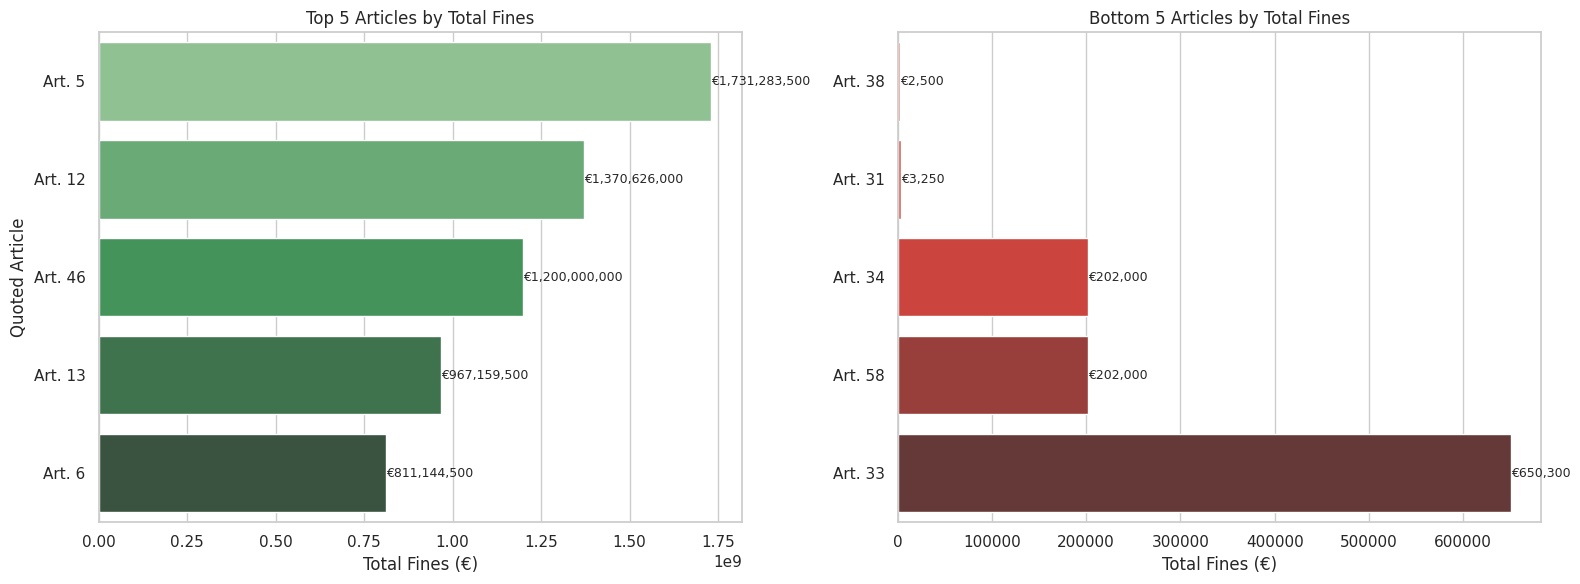

In [17]:
# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'total_fines')
bottom5 = article_summary.nsmallest(5, 'total_fines')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Total Fines')
ax1.set_xlabel('Total Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['total_fines']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Total Fines')
ax2.set_xlabel('Total Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['total_fines']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


<ipython-input-18-d336317453b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
<ipython-input-18-d336317453b4>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


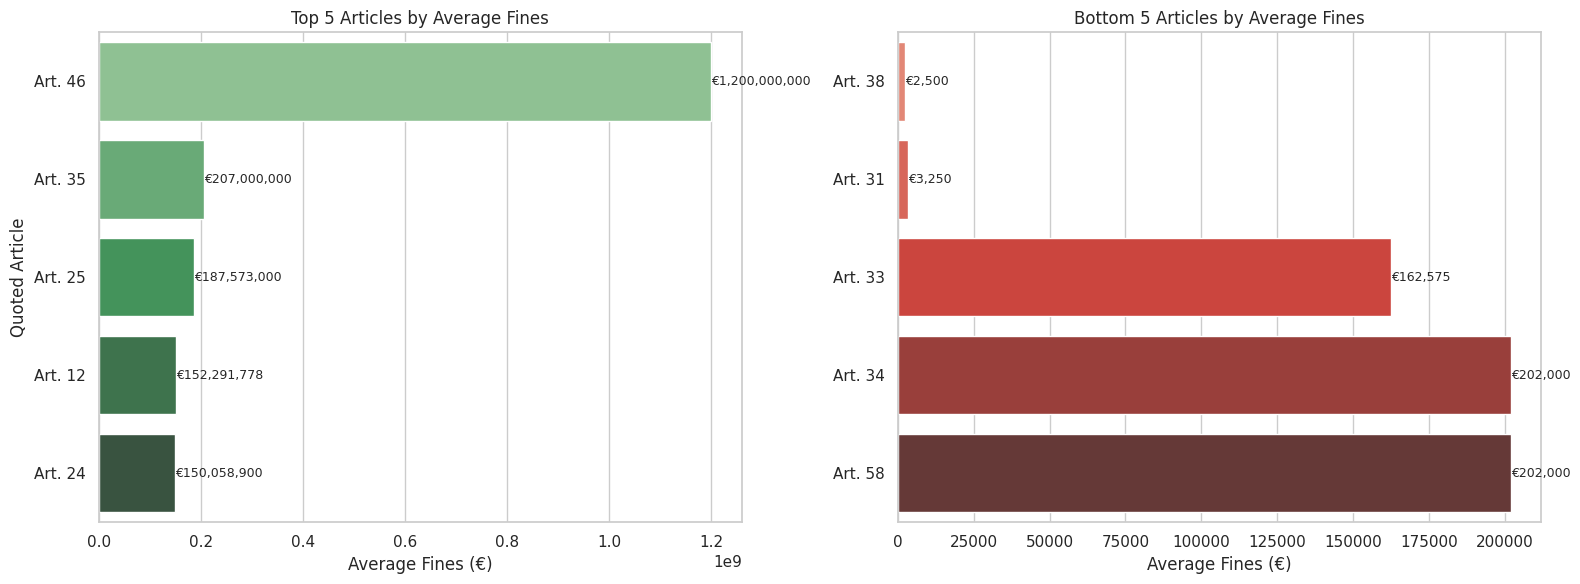

In [18]:
# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'average_fine')
bottom5 = article_summary.nsmallest(5, 'average_fine')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Average Fines')
ax1.set_xlabel('Average Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['average_fine']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Average Fines')
ax2.set_xlabel('Average Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['average_fine']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


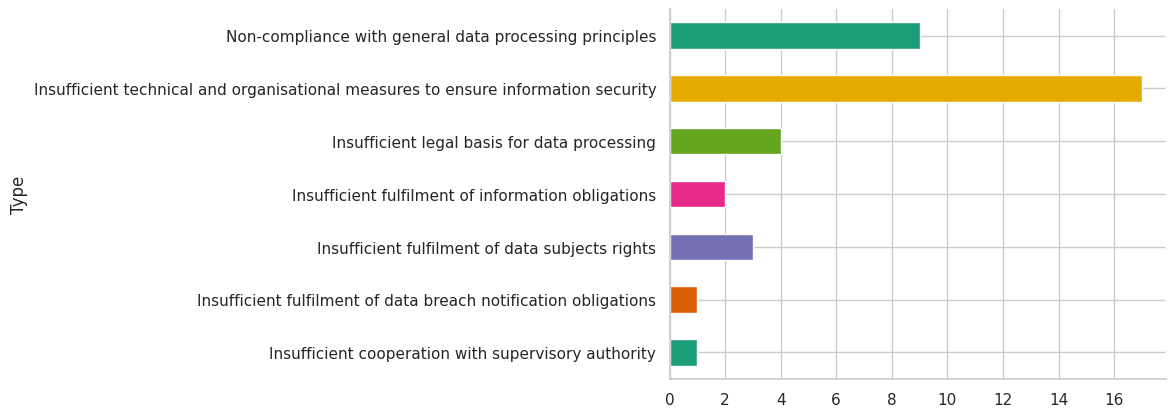

In [19]:
# @title Type

from matplotlib import pyplot as plt
import seaborn as sns
metadata_df_cleaned.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

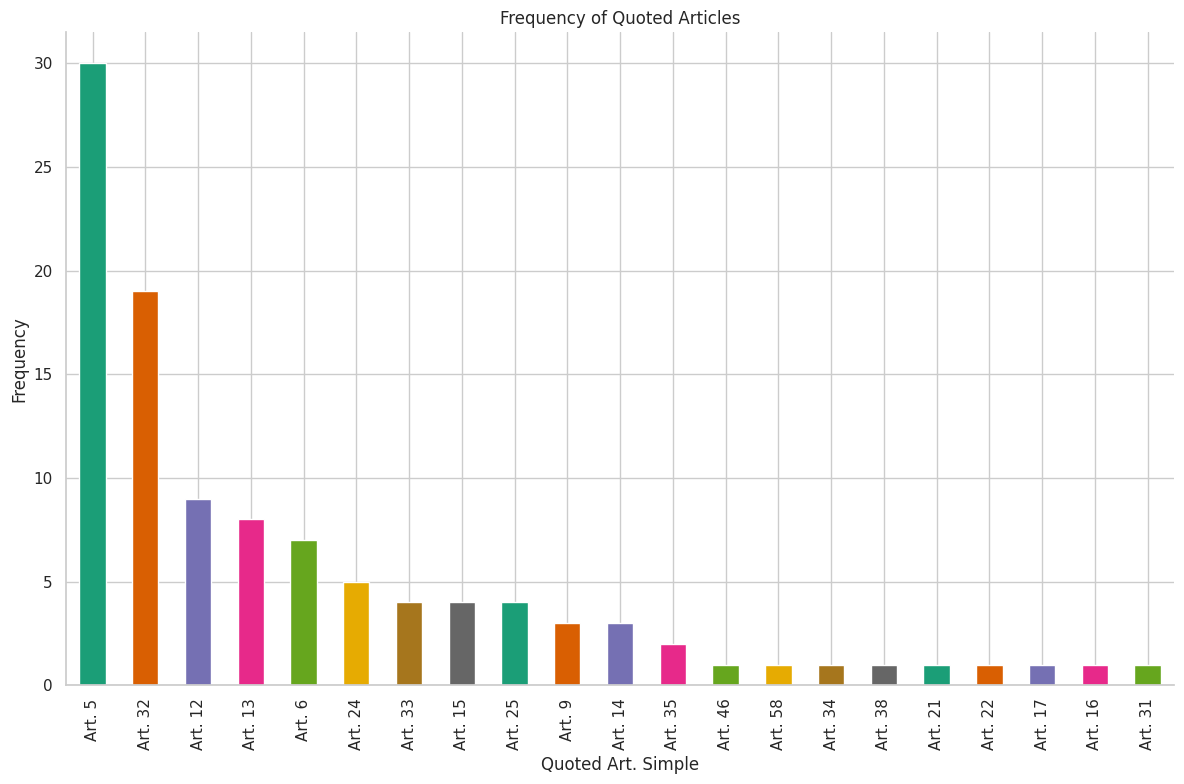

In [20]:
plt.figure(figsize=(12, 8))

# Count the occurrences of each article and plot as bar
article_counts = metadata_exploded['Quoted Art. Simple'].value_counts()

article_counts.plot(
    kind='bar',
    color=sns.color_palette('Dark2')
)

# Add labels and title
plt.title('Frequency of Quoted Articles')
plt.xlabel('Quoted Art. Simple')
plt.ylabel('Frequency')

# Improve readability
plt.xticks(rotation=90)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [21]:
# 🔎 3. Keyword frequency analysis
def keyword_frequency(text, keywords):
    return {kw: text.lower().count(kw) for kw in keywords}

keywords = ['monitoring', 'encryption', 'access control', 'destruct', 'logging', 'transfer',
            'privacy', 'rights', 'vulnerability', 'child', 'personal data', 'breach', 'risk']

keyword_df = pd.DataFrame(
    [keyword_frequency(text, keywords) for text in texts.values()],
    index=texts.keys()
)
keyword_df.to_csv('keyword_frequency.csv')
keyword_df.style.background_gradient(cmap='Blues')

,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
ETid-847.pdf,0,0,0,0,0,0,0,0,0,0,0,0,0
ETid-60.pdf,30,13,2,5,22,2,5,17,2,2,83,101,28
ETid-1844.pdf,6,8,1,0,1,550,53,185,1,0,251,64,54
ETid-689.pdf,0,0,0,0,0,2,1,22,0,0,140,59,48
ETid-1009.pdf,155,0,0,4,0,6,24,48,0,0,240,1,22
ETid-1965.pdf,0,1,1,7,0,11,22,112,1,13,245,4,43
ETid-893.pdf,0,0,0,0,0,0,0,0,0,1,5,3,1
ETid-752.pdf,0,2,1,3,0,1,4,7,3,18,24,1,12
ETid-440.pdf,6,2,0,5,0,1,5,9,2,0,107,122,57
ETid-1461.pdf,2,1,2,5,1,1,3,12,19,0,82,32,32


After the writing the keywords frequency to a csv file, the data can be read into a dataframe to avoid uploading and extarcting each PDF again.

In [22]:
keywords_df = pd.read_csv('keyword_frequency.csv')

In [23]:
keywords_df.head()

,Unnamed: 0,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-847.pdf,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ETid-60.pdf,30,13,2,5,22,2,5,17,2,2,83,101,28
2,ETid-1844.pdf,6,8,1,0,1,550,53,185,1,0,251,64,54
3,ETid-689.pdf,0,0,0,0,0,2,1,22,0,0,140,59,48
4,ETid-1009.pdf,155,0,0,4,0,6,24,48,0,0,240,1,22


In [24]:
metadata_exploded['ETid'] = metadata_exploded['ETid'].astype(str).str.strip() + '.pdf'

merged_df = metadata_exploded.merge(keywords_df, left_on='ETid', right_on='Unnamed: 0')

In [25]:
merged_df.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,...,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
1,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 32 (1),Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
2,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 33 (1) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
3,ETid-2561.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,...,0,0,0,0,0,0,0,0,0,0
4,ETid-2555.pdf,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,...,2,0,1,2,10,0,5,66,42,48


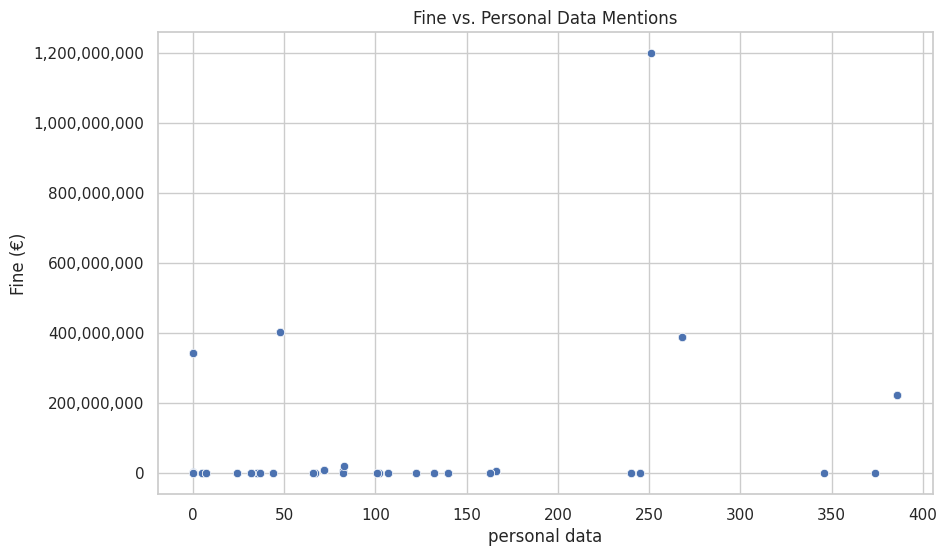

In [26]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='personal data', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Personal Data Mentions')
plt.show()

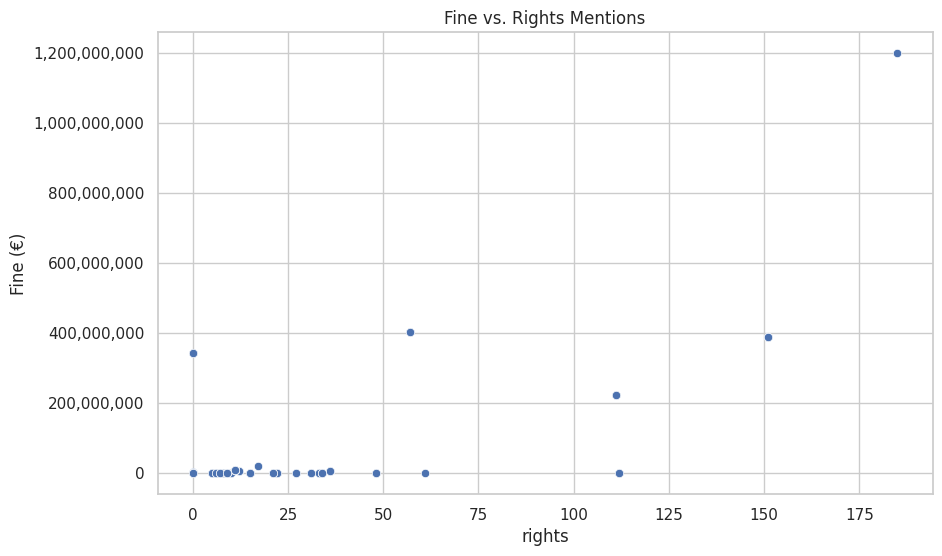

In [27]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='rights', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Rights Mentions')
plt.show()

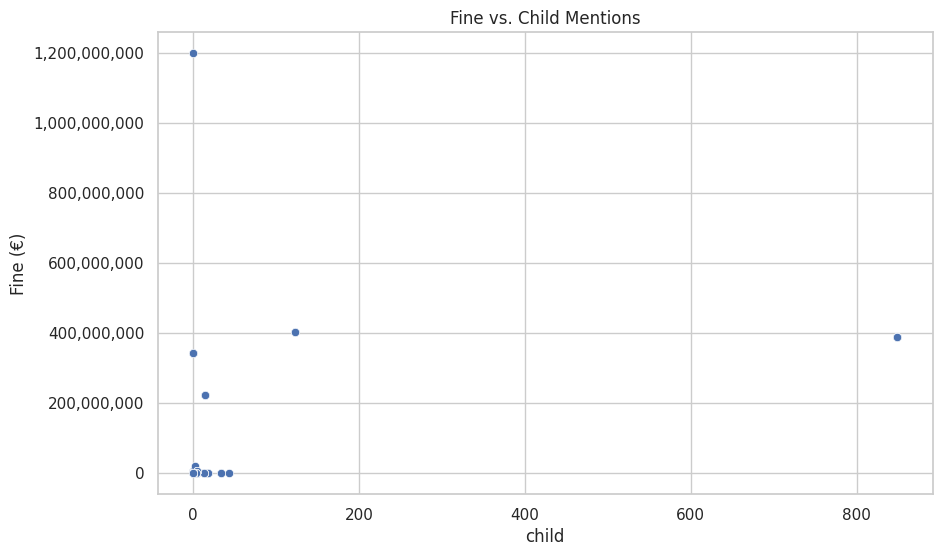

In [28]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='child', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Child Mentions')
plt.show()

In [44]:
def get_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
    ]
    return tokens

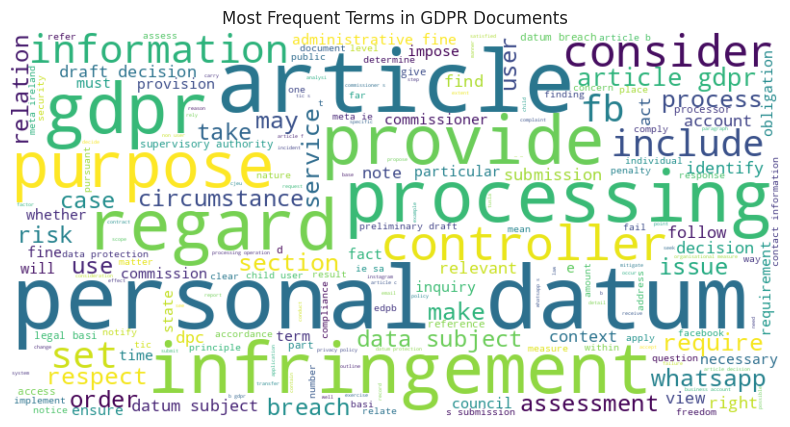

In [47]:
raw_texts = [get_text(text) for text in texts.values()]
text_string = " ".join([" ".join(raw_texts) for raw_texts in raw_texts ])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

In [49]:
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return tokens

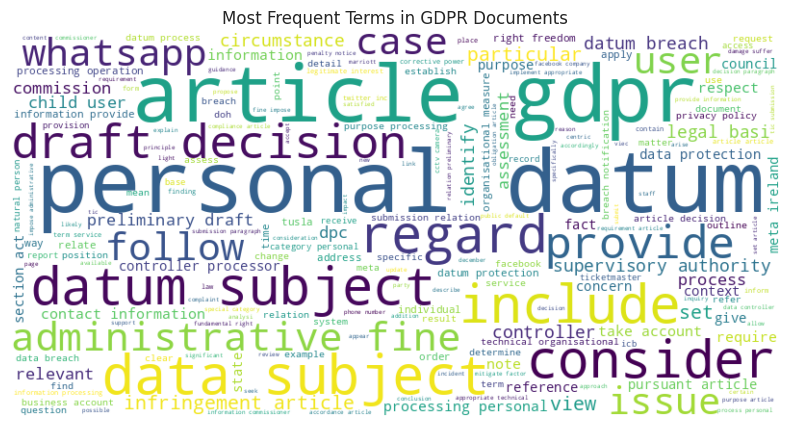

In [50]:
# Assuming `cleaned_text` contains your preprocessed text (no stopwords, lowercased, lemmatized)
# Correctly apply clean_text to each text in the texts dictionary
cleaned_texts = [clean_text(text) for text in texts.values()]
text_string = " ".join([" ".join(cleaned_text) for cleaned_text in cleaned_texts ])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

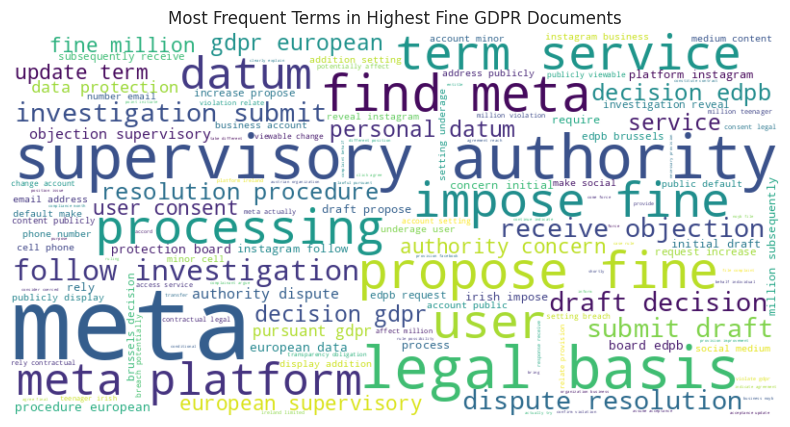

In [48]:
# 1. Filter for highest fines
# Assuming 'merged_df' contains your fine and text data
highest_fines_df = merged_df.nlargest(10, 'Fine [€]') # Select top 10 based on Fine column

# 2. Combine text from highest fine documents
text_string = " ".join(highest_fines_df['Summary'].astype(str).tolist()) # Assuming 'Text' column holds the text

# 3. Preprocess text (clean, tokenize, etc.) if not already done
# This step is important to remove irrelevant words (stop words, punctuation) and improve visualization
# You might have functions like 'clean_text' from earlier parts of the code

cleaned_text = clean_text(text_string)  # Example assuming 'clean_text' function is available
text_string = " ".join(cleaned_text)

# 4. Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in Highest Fine GDPR Documents")
plt.show()

         filename  num_words  num_chars  avg_word_length
0    ETid-847.pdf          0          8         0.000000
1     ETid-60.pdf      30244     194635         6.435491
2   ETid-1844.pdf      85497     524187         6.131057
3    ETid-689.pdf      20174     127559         6.322940
4   ETid-1009.pdf      43003     267138         6.212078
5   ETid-1965.pdf      42947     268774         6.258272
6    ETid-893.pdf        356       2305         6.474719
7    ETid-752.pdf       7189      44987         6.257755
8    ETid-440.pdf      19950     130560         6.544361
9   ETid-1461.pdf      11776      77603         6.589929
10  ETid-1696.pdf          0         33         0.000000
11   ETid-875.pdf      45712     287159         6.281917
12   ETid-552.pdf        271       1701         6.276753
13  ETid-2561.pdf          0         57         0.000000
14  ETid-1250.pdf       7325      46114         6.295427
15  ETid-1352.pdf          0         17         0.000000
16   ETid-318.pdf          0   

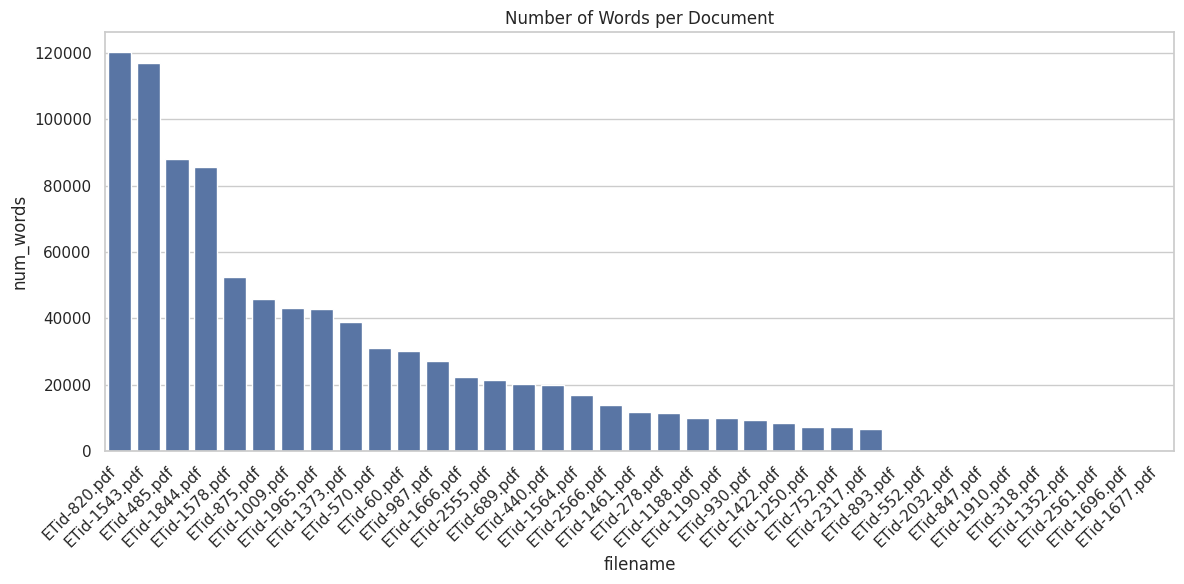

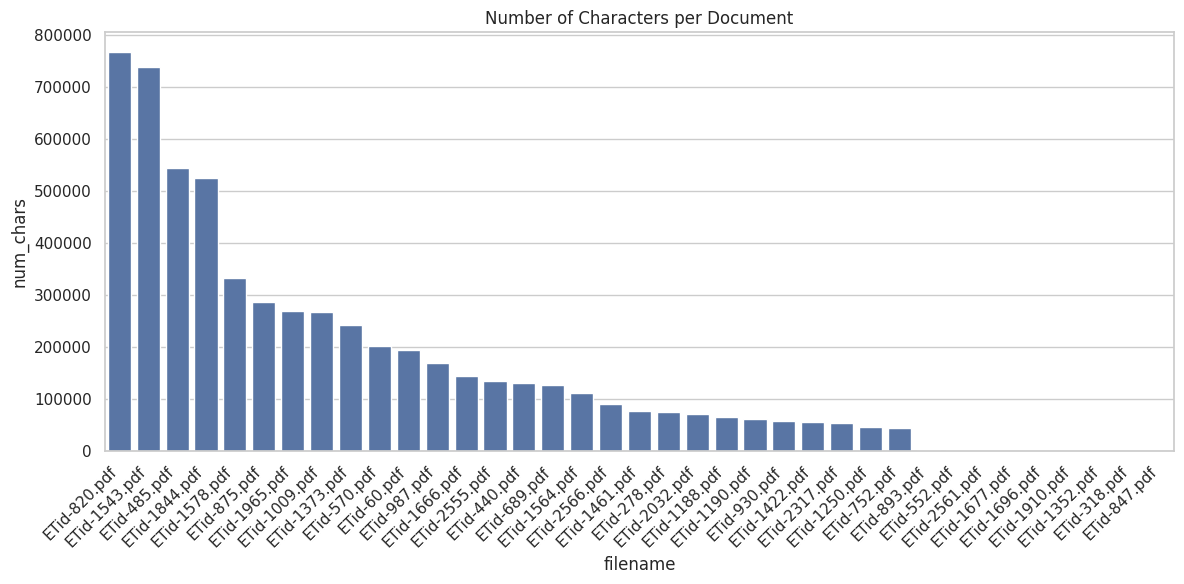


Top 10 1-grams:
data: 10709
article: 7315
gdpr: 5484
processing: 4749
personal: 4435
information: 4090
decision: 3322
controller: 2358
breach: 2231
whatsapp: 2230

Top 10 2-grams:
personal data: 4183
data subjects: 1469
article 83: 1223
draft decision: 1007
data protection: 987
article gdpr: 967
data subject: 897
article 33: 839
data breach: 767
processing personal: 674

Top 10 3-grams:
processing personal data: 660
personal data breach: 582
article 83 gdpr: 557
technical organisational measures: 366
article 65 decision: 347
categories personal data: 245
contact information processing: 240
relation preliminary draft: 226
submissions relation preliminary: 223
appropriate technical organisational: 209


In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# 📊 2. Compute text statistics
def compute_text_stats(texts):
    stats = []
    for filename, text in texts.items():
        words = text.split()
        stats.append({
            'filename': filename,
            'num_words': len(words),
            'num_chars': len(text),
            'avg_word_length': len(text) / len(words) if words else 0
        })
    return pd.DataFrame(stats)

# 🔠 3. Visualize text stats
def visualize_stats(stats_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=stats_df.sort_values(by='num_words', ascending=False), x='filename', y='num_words')
    plt.xticks(rotation=45, ha='right')
    plt.title("Number of Words per Document")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=stats_df.sort_values(by='num_chars', ascending=False), x='filename', y='num_chars')
    plt.xticks(rotation=45, ha='right')
    plt.title("Number of Characters per Document")
    plt.tight_layout()
    plt.show()

# 🔁 4. N-gram Extraction (top 10 for each n)
def get_top_ngrams(texts, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    all_text = list(texts.values())
    X = vectorizer.fit_transform(all_text)
    counts = X.sum(axis=0).A1
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), counts))
    return Counter(ngram_freq).most_common(top_k)

# 📂 5. Run
'''
pdf_dir = 'gdpr_pdfs'
texts = extract_text_from_pdfs(pdf_dir)
print(f"Extracted {len(texts)} PDF(s).")
'''
# Stats & Visuals
stats_df = compute_text_stats(texts)
print(stats_df)
visualize_stats(stats_df)

# N-grams
for n in [1, 2, 3]:
    top_ngrams = get_top_ngrams(texts, n=n)
    print(f"\nTop {len(top_ngrams)} {n}-grams:")
    for phrase, freq in top_ngrams:
        print(f"{phrase}: {freq}")

In [54]:
def plot_coherence_vs_topics(texts, start=2, limit=20, step=2):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    coherences = []
    topic_range = list(range(start, limit, step))

    for num_topics in topic_range:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary,
                                passes=20, alpha='asymmetric', eta='auto', random_state=42)
        coherence = CoherenceModel(model=model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v').get_coherence()
        coherences.append(coherence)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherences, marker='o')
    plt.title('Coherence Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

    # Return both for further use
    return topic_range, coherences

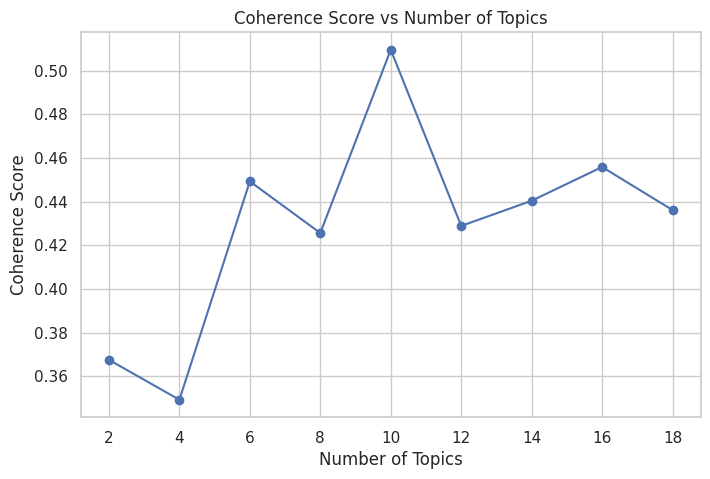

Best number of topics: 10


In [55]:
topic_range, coherences = plot_coherence_vs_topics(texts)

# Find the best number of topics
max_index = coherences.index(max(coherences))
best_num_topics = topic_range[max_index]

print(f"Best number of topics: {best_num_topics}")

In [56]:
# 🧠 LDA Topic Modeling Function

def perform_topic_modeling(texts, num_topics=best_num_topics, passes=30):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        alpha='asymmetric',
        eta='auto',
        random_state=42
    )

    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f"Coherence Score: {coherence_score:.4f}")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx}: {topic}")

    return lda_model, corpus, dictionary, tokenized_docs


In [57]:
lda_model, corpus, dictionary, tokenized_docs = perform_topic_modeling(texts)

Coherence Score: 0.5091
Topic 0: 0.085*"meta" + 0.069*"edpb" + 0.034*"objection" + 0.019*"cjeu" + 0.019*"sas" + 0.019*"dpc" + 0.011*"charter" + 0.011*"bind" + 0.010*"fundamental" + 0.010*"country"
Topic 1: 0.022*"inquiry" + 0.021*"department" + 0.021*"dpc" + 0.009*"paper" + 0.008*"advice" + 0.008*"reprimand" + 0.008*"server" + 0.007*"appendix" + 0.007*"officer" + 0.006*"necessity"
Topic 2: 0.044*"representation" + 0.023*"para" + 0.022*"customer" + 0.021*"attack" + 0.019*"payment" + 0.018*"image" + 0.017*"database" + 0.017*"rap" + 0.014*"card" + 0.014*"dpa"
Topic 3: 0.150*"council" + 0.062*"camera" + 0.034*"garda" + 0.024*"traffic" + 0.022*"management" + 0.021*"centre" + 0.019*"monitoring" + 0.019*"inquiry" + 0.017*"síochána" + 0.011*"officer"
Topic 4: 0.029*"ico" + 0.017*"release" + 0.013*"tribunal" + 0.013*"trust" + 0.012*"dpa" + 0.012*"officer" + 0.011*"contravention" + 0.010*"cyber" + 0.010*"training" + 0.008*"alert"
Topic 5: 0.067*"child" + 0.054*"instagram" + 0.026*"dpc" + 0.024*"

In [58]:
# 📌 5. Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'MONEY']]

for filename, text in texts.items():
    entities = extract_entities(text)
    top_entities = pd.Series([ent[0] for ent in entities]).value_counts().head(20)
    print(f"\n📄 {filename} → {top_entities.to_dict()}")



📄 ETid-847.pdf → {}

📄 ETid-60.pdf → {'Marriott': 414, 'GDPR': 74, 'RAP': 73, "Marriott's": 53, 'DPA': 46, "Marriott's First Representations": 29, 'EU': 26, "Marriott's Second Representations": 25, 'CDE': 23, 'Attack': 18, 'Attacker': 16, 'Starwood': 14, 'MFA': 13, 'Board': 7, 'the Draft Internal Procedure': 7, 'First Representations': 7, 'Guardium': 7, 'inter alia': 6, 'Tribunal': 6, 'UK': 5}

📄 ETid-1844.pdf → {'US': 308, 'EU': 283, 'GDPR': 210, 'CJEU': 197, 'Meta IE': 170, 'Meta Ireland': 164, 'PDD': 115, 'DPC': 57, 'Response': 50, 'the Data Transfers': 46, 'EO': 45, 'Meta IE’s': 45, 'the IE SA': 44, 'RPDD': 40, 'EEA': 39, 'ROS': 29, 'the United States': 29, 'Clauses': 28, 'EDPB': 26, 'USG': 26}

📄 ETid-689.pdf → {'ICB': 381, 'GDPR': 77, 'DPC': 10, 'ISO': 10, 'Inquiry': 8, 'the Draft Inquiry Report': 7, 'Notice': 6, 'EU': 6, 'the Final Inquiry Report': 4, 'Irish Credit Bureau': 4, '90,000': 4, 'DAC': 4, 'PP Update': 3, 'ISO27001': 3, '10,000,000': 3, 'Court': 3, 'Certification Euro

In [84]:
# 📌 Modified NER Function: Return only entities to remove

def get_entities_to_remove(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE']]

# 📌 Remove NER entities from text
def remove_entities(text, entities):
    for ent in entities:
        text = text.replace(ent, '')
    return text

# 📌 Process all documents
cleaned_texts = {}
for filename, text in texts.items():
    entities_to_remove = get_entities_to_remove(text)
    cleaned = remove_entities(text, entities_to_remove)
    cleaned_texts[filename] = cleaned

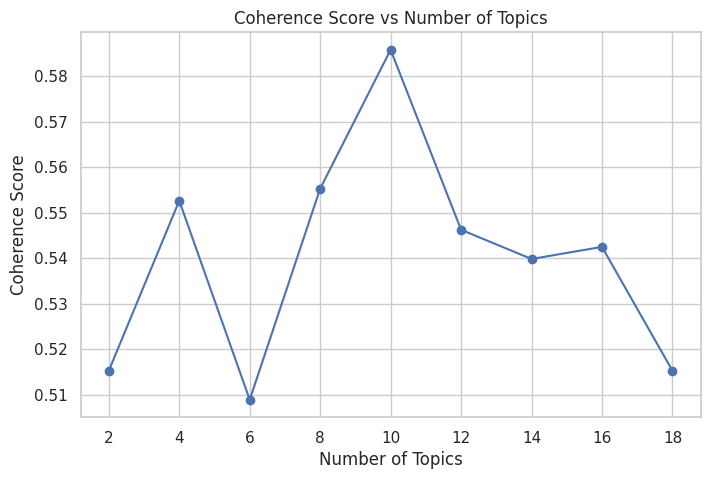

Best number of topics: 16


In [101]:
plot_coherence_vs_topics(cleaned_texts)

max_index = coherences.index(max(coherences))
best_num_topics = topic_range[max_index]

print(f"Best number of topics: {best_num_topics}")

In [102]:
lda_model_cleaned, corpus_cleaned, dictionary_cleaned, tokenized_docs_cleaned = perform_topic_modeling(cleaned_texts,10,40)

Coherence Score: 0.6053
Topic 0: 0.022*"icle" + 0.017*"accot" + 0.017*"urity" + 0.016*"subje" + 0.014*"cle" + 0.011*"testing" + 0.011*"cision" + 0.010*"alert" + 0.009*"management" + 0.009*"database"
Topic 1: 0.016*"june" + 0.015*"para" + 0.013*"payment" + 0.013*"customer" + 0.012*"release" + 0.011*"officer" + 0.011*"database" + 0.009*"attack" + 0.009*"september" + 0.009*"approach"
Topic 2: 0.041*"ersonal" + 0.028*"urose" + 0.027*"rovide" + 0.026*"rotection" + 0.026*"erson" + 0.025*"rocesse" + 0.025*"rocessing" + 0.021*"aroriate" + 0.018*"icle" + 0.014*"subje"
Topic 3: 0.119*"icle" + 0.090*"objection" + 0.028*"child" + 0.018*"ght" + 0.017*"legitimate" + 0.013*"ssion" + 0.013*"default" + 0.012*"contract" + 0.010*"necessity" + 0.010*"argue"
Topic 4: 0.046*"der" + 0.037*"ersonal" + 0.027*"rocessor" + 0.025*"rovide" + 0.020*"on" + 0.019*"suervisory" + 0.016*"accot" + 0.015*"theore" + 0.013*"urose" + 0.013*"rocess"
Topic 5: 0.064*"ice" + 0.061*"rovide" + 0.031*"rocesse" + 0.028*"rocessing" +

In [108]:
import glob

# Adjust the folder path as needed
pdf_folder = "gdpr_pdfs"  # Update this!
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

In [109]:
# Assign dominant topic to each document
dominant_topics = []
filenames = list(texts.keys())  # assuming 'texts' is a dict {filename: text}

for i, bow in enumerate(corpus_cleaned):
    topic_dist = lda_model_cleaned.get_document_topics(bow)
    top_topic = max(topic_dist, key=lambda x: x[1])  # (topic_id, confidence)
    dominant_topics.append({
        "Filename": os.path.basename(filenames[i]).replace(".pdf", ""),
        "Dominant_Topic": top_topic[0],
        "Topic_Confidence": top_topic[1]
    })

# Convert to DataFrame
doc_topics_df = pd.DataFrame(dominant_topics)
doc_topics_df.set_index("Filename", inplace=True)

# Show result
print(doc_topics_df)
doc_topics_df.to_csv('doc_topics.csv')

           Dominant_Topic  Topic_Confidence
Filename                                   
ETid-847                0              0.20
ETid-60                 1              1.00
ETid-1844               4              0.41
ETid-689                0              0.72
ETid-1009               8              1.00
ETid-1965               2              1.00
ETid-893                8              0.43
ETid-752                6              0.47
ETid-440                1              1.00
ETid-1461               6              0.80
ETid-1696               0              0.20
ETid-875                9              1.00
ETid-552                0              0.79
ETid-2561               0              0.20
ETid-1250               6              0.88
ETid-1352               0              0.20
ETid-318                0              0.20
ETid-1373               3              1.00
ETid-1677               0              0.20
ETid-1188               6              0.91
ETid-2317               6       

In [110]:
merged = doc_topics_df.merge(metadata_df_cleaned, left_index=True, right_on='ETid', how='left')
merged.head()


,Dominant_Topic,Topic_Confidence,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary
63,0,0.20,ETid-847,ISLE OF MAN,Information Commissioner of Isle of Man,2020-12-11 00:00:00,3250,Cosmetic Medical Limited,Industry and Commerce,[31 GDPR],Insufficient cooperation with supervisory auth...,The DPA of Isle of Man has imposed a fine of E...
16,1,1.00,ETid-60,UNITED KINGDOM,Information Commissioner (ICO),2020-10-30 00:00:00,20450000,"Marriott International, Inc",Accomodation and Hospitalty,[32 GDPR],Insufficient technical and organisational meas...,Original Summary: The ICO issued a notice of i...
23,4,0.41,ETid-1844,IRELAND,Data Protection Authority of Ireland,2023-05-12 00:00:00,1200000000,Meta Platforms Ireland Limited,"Media, Telecoms and Broadcasting",[46 (1) GDPR],Insufficient legal basis for data processing,The Irish DPA (DPC) has fined Meta Platforms I...
41,0,0.72,ETid-689,IRELAND,Data Protection Authority of Ireland,2021-03-23 00:00:00,90000,Irish Credit Bureau DAC,"Finance, Insurance and Consulting","[5 (2) GDPR, 24 (1) GDPR, 25 (1) GDPR]",Insufficient technical and organisational meas...,The Irish DPA (DPC) has imposed a fine of EUR ...
35,8,1.00,ETid-1009,IRELAND,Data Protection Authority of Ireland,2021-12-09 00:00:00,110000,Limerick City and County Council,Public Sector and Education,"[13 GDPR, 12 GPDR, 15 GDPR]",Insufficient fulfilment of data subjects rights,The Irish DPA has fined Limerick City and Coun...


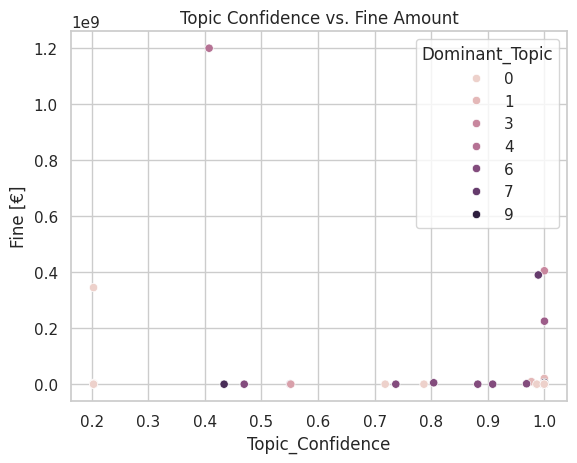

In [111]:
# Assuming 'merged_df' contains your data
sns.scatterplot(data=merged, x='Topic_Confidence', y='Fine [€]', hue='Dominant_Topic')
plt.title('Topic Confidence vs. Fine Amount')
plt.show()

<ipython-input-112-0fb93372d7b6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
<ipython-input-112-0fb93372d7b6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')


Text(0.5, 0, 'Dominant Topic')

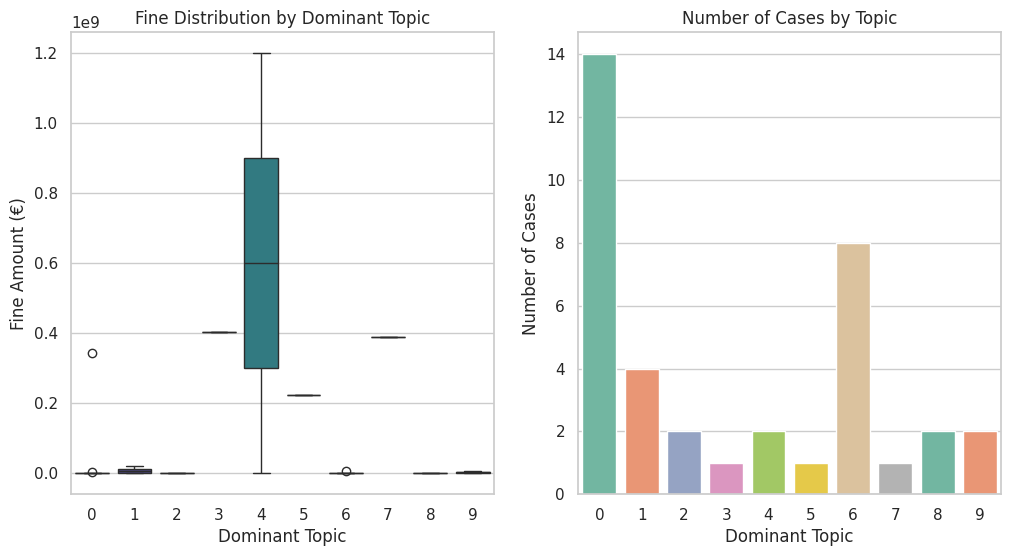

In [112]:
# Create visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot 1: Fine Amounts by Topic
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
plt.title("Fine Distribution by Dominant Topic")
plt.ylabel("Fine Amount (€)")
plt.xlabel("Dominant Topic")

# Plot 2: Number of Cases per Topic
plt.subplot(1, 2, 2)
sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')
plt.title("Number of Cases by Topic")
plt.ylabel("Number of Cases")
plt.xlabel("Dominant Topic")

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-114-cccfaf95db3f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
<ipython-input-114-cccfaf95db3f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')


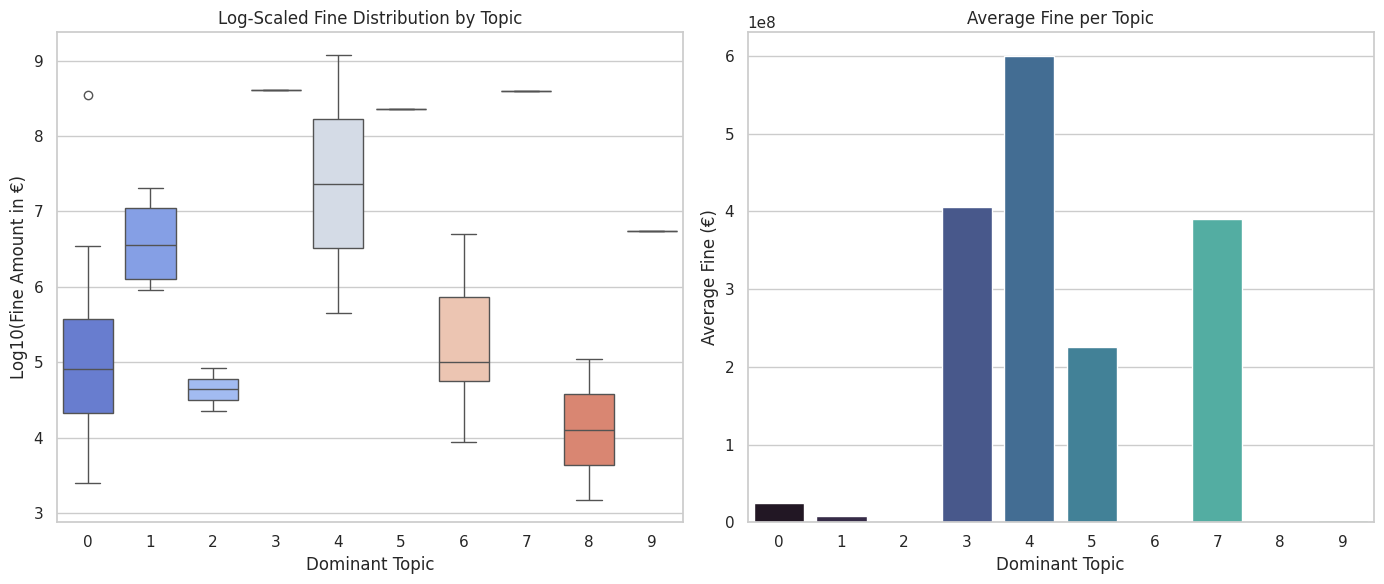

In [114]:
import numpy as np
# Log-transform fine amounts
merged['Log_Fine'] = np.log10(merged['Fine [€]'])

# Set up plots
plt.figure(figsize=(14, 6))

# Boxplot with log-scaled fines
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
plt.title("Log-Scaled Fine Distribution by Topic")
plt.ylabel("Log10(Fine Amount in €)")
plt.xlabel("Dominant Topic")

# Average fine per topic (bar)
plt.subplot(1, 2, 2)
mean_fines = merged.groupby('Dominant_Topic')['Fine [€]'].mean().reset_index()
sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')
plt.title("Average Fine per Topic")
plt.ylabel("Average Fine (€)")
plt.xlabel("Dominant Topic")

plt.tight_layout()
plt.show()

In [122]:
import scipy.stats as stats

# Assuming 'confidence_scores' and 'fine_amounts' are arrays
correlation, p_value = stats.pearsonr( merged['Dominant_Topic'], merged['Fine [€]'])
print(f"Correlation: {correlation}, p-value: {p_value}")

Correlation: 0.08030538712689578, p-value: 0.6365862621166541


In [115]:
# Assuming 'merged_df' contains your data
grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()

pd.set_option('display.float_format', '{:.2f}'.format)

print(grouped_df)

Dominant_Topic  Topic_Confidence
0               (0.203, 0.403]         108500.00
                (0.403, 0.602]               NaN
                (0.602, 0.801]          80000.00
                (0.801, 1.0]            87500.00
1               (0.203, 0.403]               NaN
                (0.403, 0.602]               NaN
                (0.602, 0.801]               NaN
                (0.801, 1.0]          5202500.00
2               (0.203, 0.403]               NaN
                (0.403, 0.602]          85000.00
                (0.602, 0.801]               NaN
                (0.801, 1.0]            22500.00
3               (0.203, 0.403]               NaN
                (0.403, 0.602]               NaN
                (0.602, 0.801]               NaN
                (0.801, 1.0]        405000000.00
4               (0.203, 0.403]               NaN
                (0.403, 0.602]     1200000000.00
                (0.602, 0.801]               NaN
                (0.801, 1.0]        

<ipython-input-115-937e3c42a391>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()


In [116]:
class RandomTopicModel:
    def __init__(self, num_topics, vocab_size):
        self.num_topics = num_topics
        self.vocab_size = vocab_size

    def get_topics(self):
        # Return a uniform distribution for each topic across all vocab terms
        return np.ones((self.num_topics, self.vocab_size)) / self.vocab_size


In [117]:
random_model = RandomTopicModel(num_topics=lda_model.num_topics, vocab_size=len(dictionary_cleaned))

In [118]:
lda_coherence_model = CoherenceModel(model=lda_model_cleaned, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

random_coherence_model = CoherenceModel(model=random_model, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
random_coherence = random_coherence_model.get_coherence()


LDA Coherence: 0.6053270679311207
Random Coherence: 0.5591175210857744


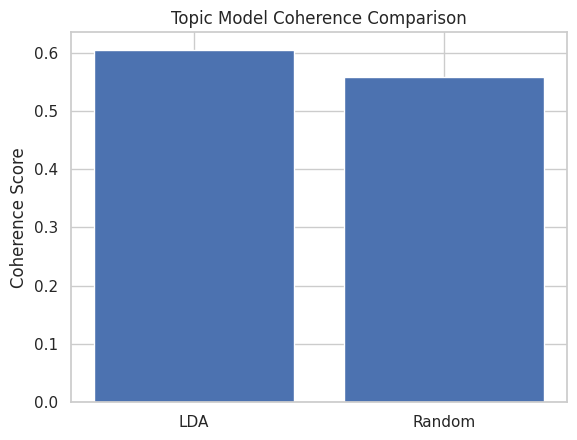

In [119]:
print(f"LDA Coherence: {lda_coherence}")
print(f"Random Coherence: {random_coherence}")

plt.bar(['LDA', 'Random'], [lda_coherence, random_coherence])
plt.title('Topic Model Coherence Comparison')
plt.ylabel('Coherence Score')
plt.show()

In [120]:
def visualize_topics(lda_model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    return vis  # Use pyLDAvis.display(vis) or pyLDAvis.save_html(vis, 'lda.html')

In [121]:
visualize_topics(lda_model_cleaned, corpus_cleaned, dictionary_cleaned)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
5      0.29  0.01       1        1 14.69
4      0.24 -0.04       2        1 13.77
7     -0.10  0.14       3        1 12.90
2      0.23 -0.05       4        1 11.67
9     -0.08  0.11       5        1 11.39
1     -0.16 -0.11       6        1 10.07
0     -0.09 -0.08       7        1  9.63
6     -0.18 -0.21       8        1  6.26
8     -0.05  0.00       9        1  5.19
3     -0.10  0.22      10        1  4.42, topic_info=              Term    Freq   Total Category  logprob  loglift
1859  commissioner  801.00  801.00  Default    30.00    30.00
1127          icle  922.00  922.00  Default    29.00    29.00
1514           ice  911.00  911.00  Default    28.00    28.00
1350        rovide 1492.00 1492.00  Default    27.00    27.00
117          child 1063.00 1063.00  Default    26.00    26.00
...            ...     ...     ...      ...      ...      ...
49        argument   31.23  270.00  Topic10    -4.91     0.96
1541   performance   23.66  143.81  Topic10    -5.19     1.31
778    undertaking   23.34  155.84  Topic10    -5.20     1.22
952     connection   18.76   78.99  Topic10    -5.42     1.68
126        clearly   19.81  179.44  Topic10    -5.36     0.91

[576 rows x 6 columns], token_table=      Topic  Freq        Term
term                         
832       2  0.05  accessible
832       4  0.13  accessible
832       5  0.13  accessible
832       6  0.05  accessible
832       7  0.05  accessible
...     ...   ...         ...
1585      9  0.17         xii
1586      7  0.68        xiii
1586      9  0.17        xiii
1587      7  0.68         xiv
1587      9  0.17         xiv

[2187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 8, 3, 10, 2, 1, 7, 9, 4])

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


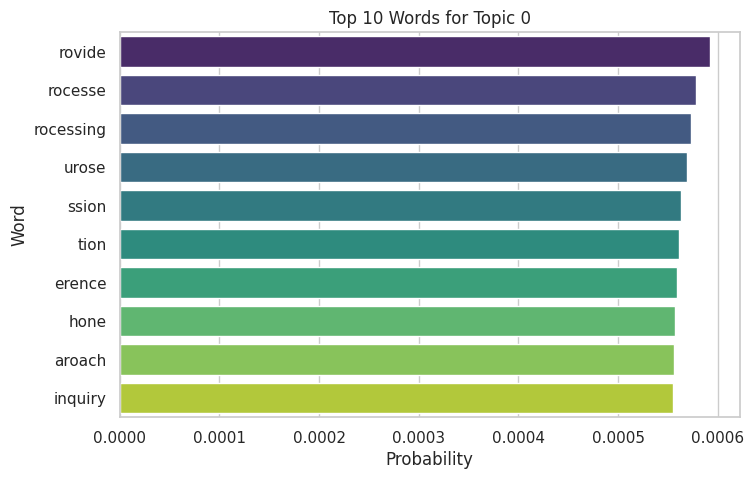

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


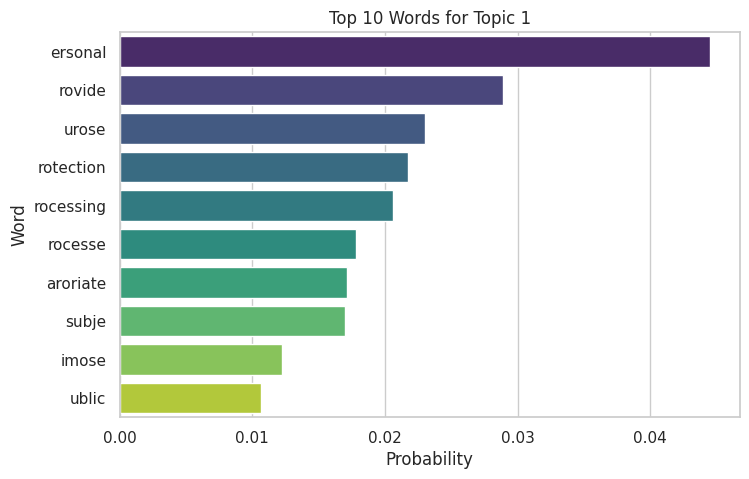

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


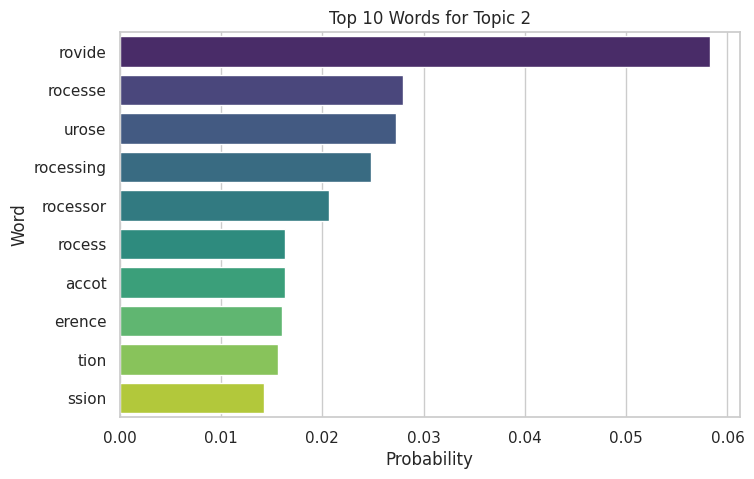

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


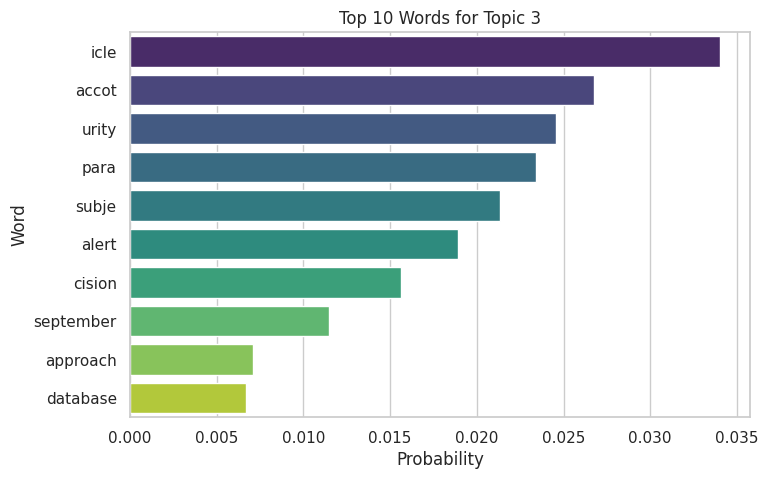

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


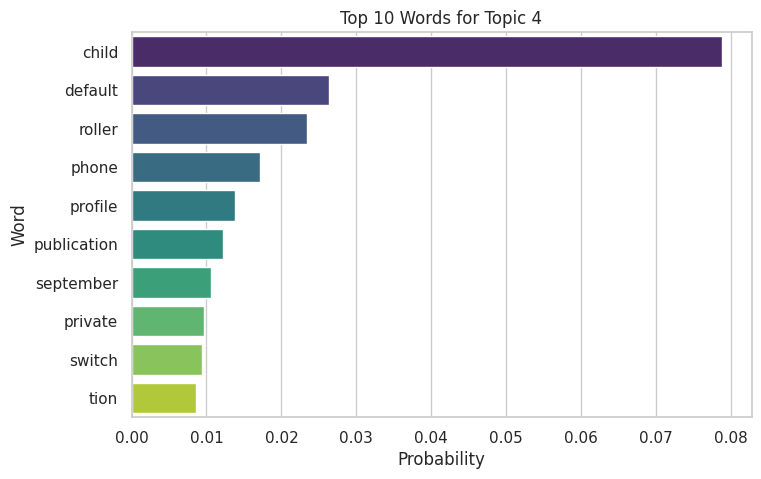

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


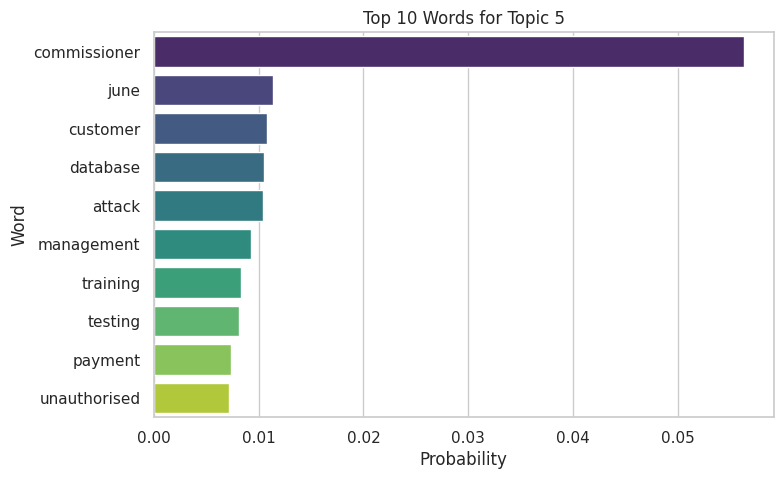

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


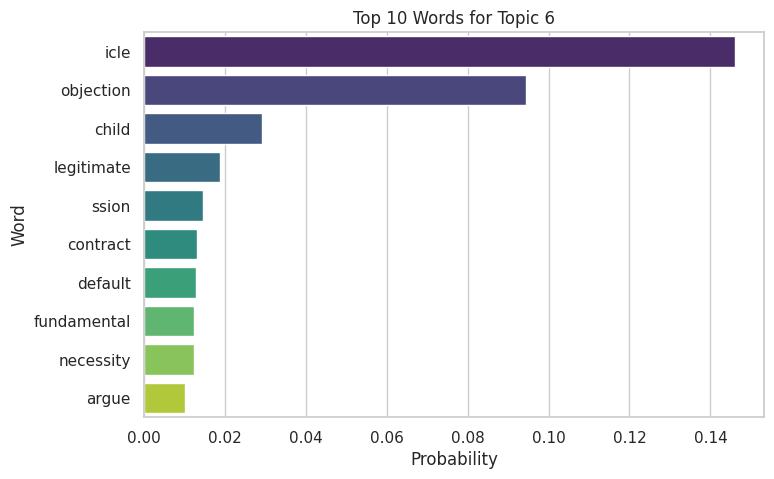

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


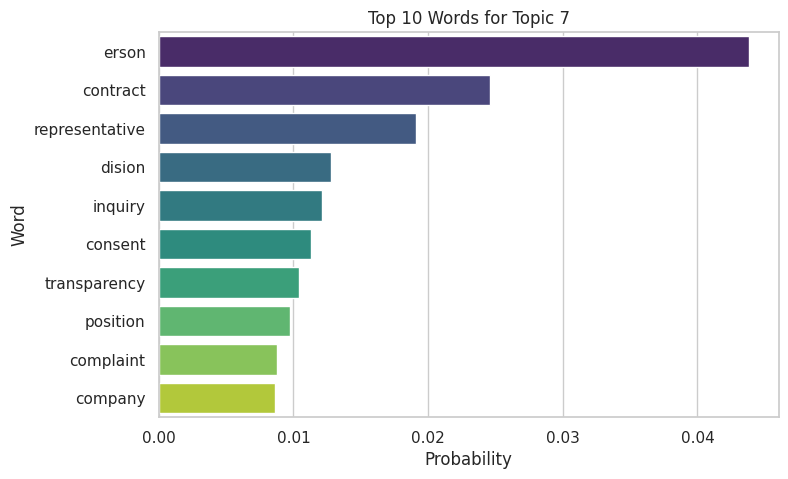

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


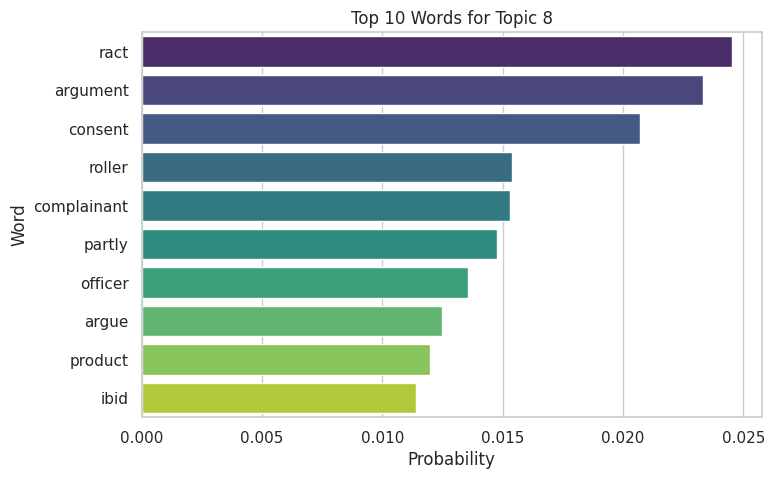

<ipython-input-71-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


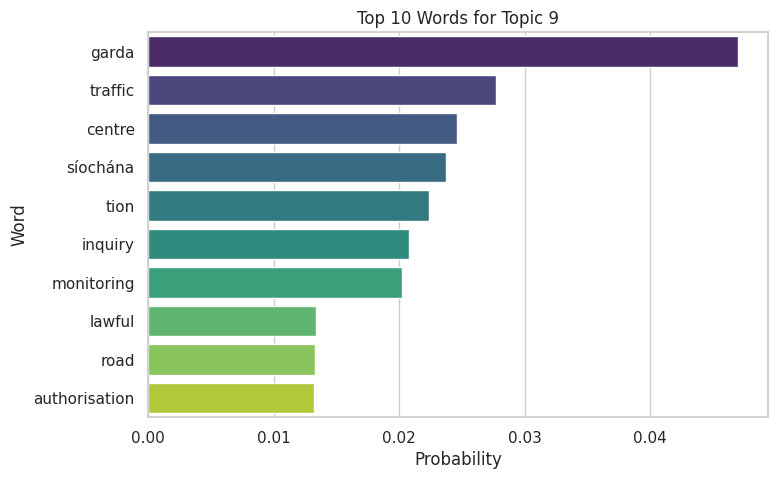

In [71]:
# Function to get top words for each topic
def plot_top_words(lda_model, num_words=10):
    for topic_id in range(lda_model.num_topics):
        words_probs = lda_model.show_topic(topic_id, topn=num_words)
        words, probs = zip(*words_probs)
        df = pd.DataFrame({'word': words, 'probability': probs})
        plt.figure(figsize=(8, 5))
        sns.barplot(x='probability', y='word', data=df, palette='viridis')
        plt.title(f"Top {num_words} Words for Topic {topic_id}")
        plt.xlabel("Probability")
        plt.ylabel("Word")
        plt.show()

plot_top_words(lda_model_cleaned)


In [ ]:
lda_model_cleaned.save('lda.model')